In [1]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Paths to your image directories
train_img_dir = "C:/Users/91897/OneDrive/Desktop/DIP/archive/dataset/train/images"
train_mask_dir = "C:/Users/91897/OneDrive/Desktop/DIP/archive/dataset/train/masks"
val_img_dir = "C:/Users/91897/OneDrive/Desktop/DIP/archive/dataset/validation/images"
val_mask_dir = "C:/Users/91897/OneDrive/Desktop/DIP/archive/dataset/validation/masks"
test_img_dir = "C:/Users/91897/OneDrive/Desktop/DIP/archive/dataset/test/images"
test_mask_dir = "C:/Users/91897/OneDrive/Desktop/DIP/archive/dataset/test/masks"

# Set the desired image size
IMG_SIZE = (128, 128)

# Load and preprocess functions
def load_and_preprocess_image(img_path, target_size=IMG_SIZE):
    img = cv2.imread(img_path, cv2.IMREAD_COLOR)
    img = cv2.resize(img, target_size)
    img = img.astype(np.float32) / 255.0
    return img

def load_and_preprocess_mask(mask_path, target_size=IMG_SIZE):
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, target_size)
    mask = mask.astype(np.float32) / 255.0
    return mask

# Load dataset function
def load_dataset(img_dir, mask_dir=None):
    images = []
    masks = []
    
    img_paths = sorted([os.path.join(img_dir, img) for img in os.listdir(img_dir) if img.endswith('.png')])
    
    mask_paths = []  # Initialize mask_paths as an empty list
    if mask_dir:
        mask_paths = sorted([os.path.join(mask_dir, mask) for mask in os.listdir(mask_dir) if mask.endswith('.png')])
    
    for img_path, mask_path in zip(img_paths, mask_paths):
        img = load_and_preprocess_image(img_path)
        images.append(img)
        
        if mask_path:
            mask = load_and_preprocess_mask(mask_path)
            masks.append(mask)
    
    return np.array(images), np.array(masks) if mask_dir else np.array(images)

# Load datasets
train_images, train_masks = load_dataset(train_img_dir, train_mask_dir)
val_images, val_masks = load_dataset(val_img_dir, val_mask_dir)
test_images = load_dataset(test_img_dir)

# Print dtype of the datasets
print(f"Train images dtype: {train_images.dtype}")
print(f"Train masks dtype: {train_masks.dtype}")

# After the preprocessing, check if they are in the desired format
if train_images.dtype != np.float32:
    train_images = train_images.astype(np.float32)

if train_masks.dtype != np.float32:
    train_masks = train_masks.astype(np.float32)

# Add a channel dimension if missing (for grayscale images)
train_images = np.expand_dims(train_images, axis=-1) if train_images.ndim == 3 else train_images
train_masks = np.expand_dims(train_masks, axis=-1) if train_masks.ndim == 3 else train_masks

# Define data augmentation parameters
data_gen_args = dict(rotation_range=30,
                     width_shift_range=0.1,
                     height_shift_range=0.1,
                     shear_range=0.2,
                     zoom_range=0.2,
                     horizontal_flip=True,
                     fill_mode='nearest')

image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen = ImageDataGenerator(**data_gen_args)

# Apply data augmentation for training images
def augment_data(images, masks, batch_size=32):
    seed = 1
    image_gen = image_datagen.flow(images, batch_size=batch_size, seed=seed)
    mask_gen = mask_datagen.flow(masks, batch_size=batch_size, seed=seed)
    return zip(image_gen, mask_gen)

# Example of how to get augmented data
augmented_data = augment_data(train_images, train_masks)


Train images dtype: float32
Train masks dtype: float32


In [2]:
# Print shapes of datasets

print("Train images shape:", train_images.shape)
print("Train masks shape:", train_masks.shape)
print("Validation images shape:", val_images.shape)
print("Validation masks shape:", val_masks.shape)
print("Test images shape:", test_images.shape)

Train images shape: (1385, 128, 128, 3)
Train masks shape: (1385, 128, 128, 1)
Validation images shape: (396, 128, 128, 3)
Validation masks shape: (396, 128, 128)


AttributeError: 'tuple' object has no attribute 'shape'

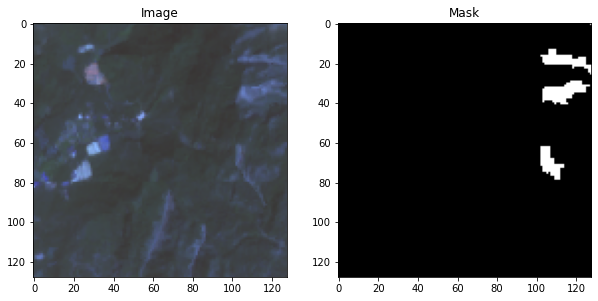

In [3]:
# Visualize Sample Images and Masks

import matplotlib.pyplot as plt

# Function to plot images and masks
def plot_sample_image_and_mask(image, mask):
    plt.figure(figsize=(10, 5))

    # Plot image
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title("Image")

    # Plot mask
    plt.subplot(1, 2, 2)
    plt.imshow(mask[:, :, 0], cmap='gray')  # Use first channel for masks
    plt.title("Mask")
    plt.show()

# Show a random sample from the training set
plot_sample_image_and_mask(train_images[0], train_masks[0])

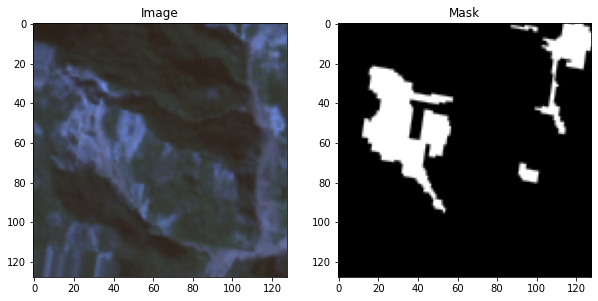

In [4]:
# Get a batch of augmented data
image_batch, mask_batch = next(augment_data(train_images, train_masks))

# Visualize augmented images and masks
plot_sample_image_and_mask(image_batch[0], mask_batch[0])

In [55]:
import tensorflow as tf
import os

# Define data paths for your landslide hazard dataset
data_dir = "C:/Users/91897/OneDrive/Desktop/DIP/archive/dataset"  # Adjust this path based on your file structure
train_img_path = os.path.join(data_dir, "C:/Users/91897/OneDrive/Desktop/DIP/archive/dataset/train/images")
train_mask_path = os.path.join(data_dir, "C:/Users/91897/OneDrive/Desktop/DIP/archive/dataset/train/masks")
val_img_path = os.path.join(data_dir, "C:/Users/91897/OneDrive/Desktop/DIP/archive/dataset/validation/images")
val_mask_path = os.path.join(data_dir, "C:/Users/91897/OneDrive/Desktop/DIP/archive/dataset/validation/masks")
test_img_path = os.path.join(data_dir, "C:/Users/91897/OneDrive/Desktop/DIP/archive/dataset/test/images")

# Verify that the paths are correctly set by printing
print("Training Images Path:", train_img_path)
print("Training Masks Path:", train_mask_path)
print("Validation Images Path:", val_img_path)
print("Validation Masks Path:", val_mask_path)
print("Test Images Path:", test_img_path)

# Image dimensions
IMG_HEIGHT = 128
IMG_WIDTH = 128

# Data loading function
def load_image_and_mask(img_path, mask_path, img_height=IMG_HEIGHT, img_width=IMG_WIDTH):
    def process_path(img_file, mask_file):
        # Load and process the image
        img = tf.io.read_file(img_file)
        img = tf.image.decode_png(img, channels=3)
        img = tf.image.resize(img, [img_height, img_width])
        img = tf.cast(img, tf.float32) / 255.0  # Normalize to [0,1]

        # Load and process the mask
        mask = tf.io.read_file(mask_file)
        mask = tf.image.decode_png(mask, channels=1)
        mask = tf.image.resize(mask, [img_height, img_width])
        mask = tf.cast(mask, tf.uint8)
        
        return img, mask

    # Get list of all image and mask files
    img_files = [os.path.join(img_path, fname) for fname in sorted(os.listdir(img_path))]
    mask_files = [os.path.join(mask_path, fname) for fname in sorted(os.listdir(mask_path))]
    
    # Create a dataset from the file paths and process them
    return tf.data.Dataset.from_tensor_slices((img_files, mask_files)).map(process_path)

# Example usage of data loading for training dataset
train_dataset = load_image_and_mask(train_img_path, train_mask_path)

# Check the first batch to confirm it loads correctly
for img, mask in train_dataset.take(1):
    print("Image shape:", img.shape)
    print("Mask shape:", mask.shape)


Training Images Path: C:/Users/91897/OneDrive/Desktop/DIP/archive/dataset/train/images
Training Masks Path: C:/Users/91897/OneDrive/Desktop/DIP/archive/dataset/train/masks
Validation Images Path: C:/Users/91897/OneDrive/Desktop/DIP/archive/dataset/validation/images
Validation Masks Path: C:/Users/91897/OneDrive/Desktop/DIP/archive/dataset/validation/masks
Test Images Path: C:/Users/91897/OneDrive/Desktop/DIP/archive/dataset/test/images
Image shape: (128, 128, 3)
Mask shape: (128, 128, 1)


## FCN8 MODEL

In [61]:
## FCN8 Architecture
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Conv2DTranspose, Input
from tensorflow.keras.models import Model

def FCN8(input_shape=(128, 128, 3), n_classes=2):
    inputs = Input(shape=input_shape)

    # Block 1
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    x = MaxPooling2D((2, 2))(x)

    # Block 2
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)

    # Block 3
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)

    # Block 4 - Upsampling
    x = Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same')(x)
    x = Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same')(x)
    x = Conv2DTranspose(n_classes, (3, 3), strides=(2, 2), padding='same', activation='softmax')(x)

    model = Model(inputs=inputs, outputs=x)
    return model

# Instantiate the model
model = FCN8(input_shape=(128, 128, 3), n_classes=2)
model.summary()


Model: "functional_31"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_31 (InputLayer)          │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_98 (Conv2D)                   │ (None, 128, 128, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_92 (MaxPooling2D)      │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_99 (Conv2D)                   │ (None, 64, 64, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_93 (MaxPooling2D)      │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_100 (Conv2D)                  │ (None, 32, 32, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_94 (MaxPooling2D)      │ (None, 16, 16, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_90                  │ (None, 32, 32, 128)         │         295,040 │
│ (Conv2DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_91                  │ (None, 64, 64, 64)          │          73,792 │
│ (Conv2DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_92                  │ (None, 128, 128, 2)         │           1,154 │
│ (Conv2DTranspose)                    │                             │                 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 740,802 (2.83 MB)

 Trainable params: 740,802 (2.83 MB)

 Non-trainable params: 0 (0.00 B)

In [2]:
import os

# Define your base data directory
data_dir = "C:/Users/91897/OneDrive/Desktop/DIP/archive/dataset/"

# Use os.path.join to concatenate paths correctly
train_img_path = os.path.join(data_dir, "train", "images")
train_mask_path = os.path.join(data_dir, "train", "masks")
val_img_path = os.path.join(data_dir, "val", "images")
val_mask_path = os.path.join(data_dir, "val", "masks")
checkpoint_filepath = os.path.join(data_dir, "fcn8_weights")

# Check paths to confirm they're correct
print("Train Images Path:", train_img_path)
print("Train Masks Path:", train_mask_path)
print("Validation Images Path:", val_img_path)
print("Validation Masks Path:", val_mask_path)
print("Checkpoint Path:", checkpoint_filepath)


Train Images Path: C:/Users/91897/OneDrive/Desktop/DIP/archive/dataset/train\images
Train Masks Path: C:/Users/91897/OneDrive/Desktop/DIP/archive/dataset/train\masks
Validation Images Path: C:/Users/91897/OneDrive/Desktop/DIP/archive/dataset/val\images
Validation Masks Path: C:/Users/91897/OneDrive/Desktop/DIP/archive/dataset/val\masks
Checkpoint Path: C:/Users/91897/OneDrive/Desktop/DIP/archive/dataset/fcn8_weights


In [53]:
## FCN8 Model Training
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Conv2DTranspose, Input, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import os

# Model Definition
def FCN8(input_shape=(256, 256, 1), n_classes=2):
    inputs = Input(shape=input_shape)

    # Encoder
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.3)(x)

    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.3)(x)

    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.3)(x)

    # Decoder
    x = Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same')(x)
    x = Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same')(x)
    x = Conv2DTranspose(n_classes, (3, 3), strides=(2, 2), padding='same', activation=None)(x)  # Logits

    return Model(inputs=inputs, outputs=x)

# Compile Model
model = FCN8(input_shape=(256, 256, 1), n_classes=2)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

# Data Loading and Preprocessing
img_size = (256, 256)
batch_size = 4
epochs = 70

def load_image(image_file):
    img = tf.io.read_file(image_file)
    img = tf.image.decode_png(img, channels=1)
    img = tf.image.resize(img, img_size)
    img = img / 255.0  # Normalize to [0, 1]
    return img

def load_mask(mask_file):
    mask = tf.io.read_file(mask_file)
    mask = tf.image.decode_png(mask, channels=1)  # Load as grayscale
    mask = tf.image.resize(mask, img_size, method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    mask = tf.squeeze(mask, axis=-1)  # Remove channel dimension
    mask = tf.cast(mask, tf.int32)  # Ensure integer labels
    
    # Replace all 255 values with 1 (valid class value)
    mask = tf.where(mask == 255, 1, mask)
    
    return mask

train_img_path = "C:/Users/91897/OneDrive/Desktop/DIP/archive/dataset/train/images"
train_mask_path = "C:/Users/91897/OneDrive/Desktop/DIP/archive/dataset/train/masks"

train_img_files = sorted([os.path.join(train_img_path, fname) for fname in os.listdir(train_img_path) if fname.endswith('.png')])
train_mask_files = sorted([os.path.join(train_mask_path, fname) for fname in os.listdir(train_mask_path) if fname.endswith('.png')])

# Dataset Creation
train_dataset = tf.data.Dataset.from_tensor_slices((train_img_files, train_mask_files))
train_dataset = train_dataset.map(lambda img, mask: (load_image(img), load_mask(mask)), num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

# Debugging Shape and Values
for images, masks in train_dataset.take(1):
    print("Image batch shape:", images.shape)  # Should be (batch_size, height, width, 1)
    print("Mask batch shape:", masks.shape)    # Should be (batch_size, height, width)
    print("Unique mask values:", tf.unique(tf.reshape(masks, [-1]))[0].numpy())  # Check values in masks

# Train Model
history = model.fit(
    train_dataset,
    epochs=epochs,
    callbacks=[EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)]
)


Image batch shape: (4, 256, 256, 1)
Mask batch shape: (4, 256, 256)
Unique mask values: [0 1]
Epoch 1/70
347/347 ━━━━━━━━━━━━━━━━━━━━ 330s 937ms/step - accuracy: 0.9208 - loss: 0.3701
Epoch 2/70
347/347 ━━━━━━━━━━━━━━━━━━━━ 291s 837ms/step - accuracy: 0.9549 - loss: 0.1582
Epoch 3/70
347/347 ━━━━━━━━━━━━━━━━━━━━ 335s 964ms/step - accuracy: 0.9548 - loss: 0.1495
Epoch 4/70
347/347 ━━━━━━━━━━━━━━━━━━━━ 318s 913ms/step - accuracy: 0.9540 - loss: 0.1431
Epoch 5/70
347/347 ━━━━━━━━━━━━━━━━━━━━ 310s 893ms/step - accuracy: 0.9574 - loss: 0.1162
Epoch 10/70
347/347 ━━━━━━━━━━━━━━━━━━━━ 318s 911ms/step - accuracy: 0.9579 - loss: 0.1131
Epoch 11/70
347/347 ━━━━━━━━━━━━━━━━━━━━ 307s 883ms/step - accuracy: 0.9582 - loss: 0.1111
Epoch 12/70
347/347 ━━━━━━━━━━━━━━━━━━━━ 311s 894ms/step - accuracy: 0.9586 - loss: 0.1093
Epoch 13/70
347/347 ━━━━━━━━━━━━━━━━━━━━ 305s 876ms/step - accuracy: 0.9588 - loss: 0.1080
Epoch 14/70
347/347 ━━━━━━━━━━━━━━━━━━━━ 310s 893ms/step - accuracy: 0.9589 - loss: 0.1069
E

In [54]:
# Set validation paths and parameters
val_img_path = os.path.join(data_dir, "C:/Users/91897/OneDrive/Desktop/DIP/archive/dataset/validation/images")
val_mask_path = os.path.join(data_dir, "C:/Users/91897/OneDrive/Desktop/DIP/archive/dataset/validation/masks")

# Load validation image and mask files
val_img_files = sorted([os.path.join(val_img_path, fname) for fname in os.listdir(val_img_path) if fname.endswith('.png')])
val_mask_files = sorted([os.path.join(val_mask_path, fname) for fname in os.listdir(val_mask_path) if fname.endswith('.png')])

# Create a tf.data.Dataset for validation
val_dataset = tf.data.Dataset.from_tensor_slices((val_img_files, val_mask_files))

# Map the load functions onto the dataset
val_dataset = val_dataset.map(lambda img, mask: (load_image(img), load_mask(mask)), num_parallel_calls=tf.data.AUTOTUNE)

# Batch and prefetch the dataset for efficiency
val_dataset = val_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

# Evaluate the model on the validation set
val_loss, val_accuracy = model.evaluate(val_dataset)

# Print validation results
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")


99/99 ━━━━━━━━━━━━━━━━━━━━ 32s 296ms/step - accuracy: 0.9684 - loss: 0.0777
Validation Loss: 0.0819
Validation Accuracy: 0.9668


In [55]:
# Save the model in `.h5` or `.keras` format
model.save('fcn8_trained_model.h5')

# Alternatively, you can use the `.keras` format if preferred
model.save('fcn8_trained_model.keras')

In [56]:
# Save the model in .h5 format
model.save("C:/Users/91897/OneDrive/Desktop/DIP/fcn_model.h5")

In [57]:
# Load the model in .h5 format
model = tf.keras.models.load_model("C:/Users/91897/OneDrive/Desktop/DIP/fcn_model.h5")

In [58]:
# Load the trained model from file
loaded_model = tf.keras.models.load_model('fcn8_trained_model.h5')

# You can now use the loaded model to predict or evaluate
loaded_model.evaluate(val_dataset)


99/99 ━━━━━━━━━━━━━━━━━━━━ 52s 404ms/step - accuracy: 0.9684 - loss: 0.0777


[0.08187790215015411, 0.9668002128601074]

In [59]:
## Performance Measure
import os
import numpy as np
import tensorflow as tf
from sklearn.metrics import confusion_matrix

# Image size for resizing
img_size = (256, 256)

# Function to preprocess test images
def preprocess_image(image_file):
    img = tf.io.read_file(image_file)
    img = tf.image.decode_png(img, channels=1)  # Load as grayscale
    img = tf.image.resize(img, img_size)
    img = img / 255.0  # Normalize to [0, 1]
    img = tf.expand_dims(img, axis=0)  # Add batch dimension
    return img

# Function to preprocess test masks
def preprocess_mask(mask_file):
    mask = tf.io.read_file(mask_file)
    mask = tf.image.decode_png(mask, channels=1)  # Grayscale
    mask = tf.image.resize(mask, img_size)
    mask = tf.round(mask / 255.0)  # Ensure binary values
    mask = tf.expand_dims(mask, axis=0)  # Add batch dimension
    return mask

# Evaluate the model on test images and masks
test_img_files = sorted([
    os.path.join("C:/Users/91897/OneDrive/Desktop/DIP/archive/dataset/test/images", fname)
    for fname in os.listdir("C:/Users/91897/OneDrive/Desktop/DIP/archive/dataset/test/images")
    if fname.endswith('.png')
])
test_mask_files = sorted([
    os.path.join("C:/Users/91897/OneDrive/Desktop/DIP/archive/dataset/test/masks", fname)
    for fname in os.listdir("C:/Users/91897/OneDrive/Desktop/DIP/archive/dataset/test/masks")
    if fname.endswith('.png')
])

# Initialize metric lists
accuracies = []
precisions = []
recalls = []
dice_scores = []
ious = []

for img_file, mask_file in zip(test_img_files, test_mask_files):
    # Preprocess image and mask
    img = preprocess_image(img_file)
    mask = preprocess_mask(mask_file)
    
    # Get prediction
    pred_mask = model.predict(img, verbose=0)
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = tf.expand_dims(pred_mask, axis=-1)
    
    # Convert to numpy arrays
    y_true = mask.numpy().astype(np.int32).flatten()
    y_pred = pred_mask.numpy().astype(np.int32).flatten()
    
    # Calculate confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
    true_positive = cm[1, 1]
    false_positive = cm[0, 1]
    false_negative = cm[1, 0]
    true_negative = cm[0, 0]
    
    # Calculate metrics
    acc = (true_positive + true_negative) / (cm.sum())
    prec = true_positive / (true_positive + false_positive) if (true_positive + false_positive) != 0 else 0
    rec = true_positive / (true_positive + false_negative) if (true_positive + false_negative) != 0 else 0
    dice = (2 * prec * rec) / (prec + rec) if (prec + rec) != 0 else 0
    iou = true_positive / (true_positive + false_positive + false_negative) if (true_positive + false_positive + false_negative) != 0 else 0
    
    # Append metrics
    accuracies.append(acc)
    precisions.append(prec)
    recalls.append(rec)
    dice_scores.append(dice)
    ious.append(iou)

# Calculate mean metrics
mean_accuracy = np.mean(accuracies)
mean_precision = np.mean(precisions)
mean_recall = np.mean(recalls)
mean_dice_score = np.mean(dice_scores)
mean_iou = np.mean(ious)

# Print results
print(f"Mean Accuracy: {mean_accuracy:.4f}")
print(f"Mean Precision: {mean_precision:.4f}")
print(f"Mean Recall: {mean_recall:.4f}")
print(f"Mean Dice Similarity Score: {mean_dice_score:.4f}")
print(f"Mean IoU: {mean_iou:.4f}")


Mean Accuracy: 0.9624
Mean Precision: 0.6407
Mean Recall: 0.3541
Mean Dice Similarity Score: 0.4115
Mean IoU: 0.2816


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


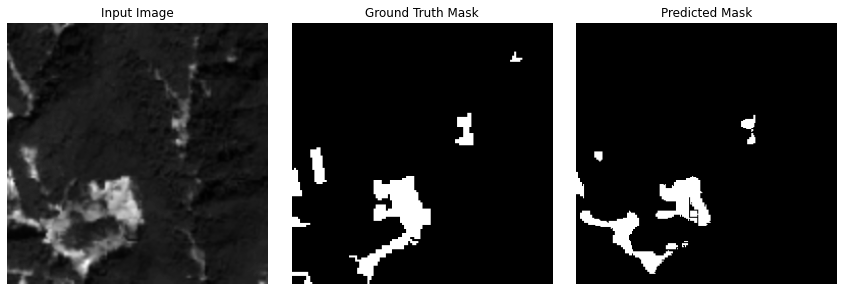

In [60]:
## Visualisation
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os

# Function to load and preprocess images
def load_image(image_file, img_size=(256, 256)):
    img = tf.io.read_file(image_file)
    img = tf.image.decode_png(img, channels=1)  # Load as grayscale
    img = tf.image.resize(img, img_size)
    img = img / 255.0  # Normalize to [0, 1]
    return img

# Function to load and preprocess masks
def load_mask(mask_file, img_size=(256, 256)):
    mask = tf.io.read_file(mask_file)
    mask = tf.image.decode_png(mask, channels=1)  # Load as grayscale
    mask = tf.image.resize(mask, img_size, method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    mask = tf.squeeze(mask, axis=-1)  # Remove channel dimension
    mask = tf.cast(mask / 255, tf.int32)  # Normalize to [0, 1] and cast to int
    return mask

# Visualization function
def visualize_predictions(image, ground_truth, prediction):
    # Ensure inputs are numpy arrays
    if isinstance(image, tf.Tensor):
        image = image.numpy()
    if isinstance(ground_truth, tf.Tensor):
        ground_truth = ground_truth.numpy()
    if isinstance(prediction, tf.Tensor):
        prediction = prediction.numpy()

    plt.figure(figsize=(12, 4))
    
    # Input Image
    plt.subplot(1, 3, 1)
    plt.title("Input Image")
    plt.imshow(image.squeeze(), cmap='gray')  # Squeeze to remove extra dimensions
    plt.axis('off')

    # Ground Truth Mask
    plt.subplot(1, 3, 2)
    plt.title("Ground Truth Mask")
    plt.imshow(ground_truth, cmap='gray')
    plt.axis('off')

    # Predicted Mask
    plt.subplot(1, 3, 3)
    plt.title("Predicted Mask")
    plt.imshow(prediction, cmap='gray')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

# Paths to test dataset
test_img_path = "C:/Users/91897/OneDrive/Desktop/DIP/archive/dataset/test/images"  # Update with the correct path
test_mask_path = "C:/Users/91897/OneDrive/Desktop/DIP/archive/dataset/test/masks" # Update with the correct path

# Load test file paths
test_img_files = sorted([os.path.join(test_img_path, fname) for fname in os.listdir(test_img_path) if fname.endswith('.png')])
test_mask_files = sorted([os.path.join(test_mask_path, fname) for fname in os.listdir(test_mask_path) if fname.endswith('.png')])

# Load a single test image and mask
test_image = load_image(test_img_files[0])  # Replace [0] with an index to test different samples
test_mask = load_mask(test_mask_files[0])

# Predict the mask using the trained model
prediction = model.predict(tf.expand_dims(test_image, axis=0))  # Add batch dimension
predicted_mask = np.argmax(prediction[0], axis=-1)  # Convert probabilities to class labels

# Visualize the results
visualize_predictions(test_image, test_mask, predicted_mask)


In [ ]:
pip install torch torchvision numpy pillow

In [37]:
pip install torchvision

Note: you may need to restart the kernel to use updated packages.


In [23]:
pip install --upgrade keras

  Attempting uninstall: keras
    Found existing installation: keras 3.5.0
    Uninstalling keras-3.5.0:
      Successfully uninstalled keras-3.5.0
Note: you may need to restart the kernel to use updated packages.


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-cpu 2.17.0 requires tensorflow-intel==2.17.0; platform_system == "Windows", but you have tensorflow-intel 2.18.0 which is incompatible.


In [25]:
pip install --upgrade tensorflow

In [33]:
pip install torchsummary

Note: you may need to restart the kernel to use updated packages.


In [69]:
pip install flask_sqlalchemy

  Attempting uninstall: MarkupSafe
    Found existing installation: MarkupSafe 2.0.1
    Uninstalling MarkupSafe-2.0.1:
      Successfully uninstalled MarkupSafe-2.0.1
  Attempting uninstall: Werkzeug
    Found existing installation: Werkzeug 2.0.3
    Uninstalling Werkzeug-2.0.3:
      Successfully uninstalled Werkzeug-2.0.3
  Attempting uninstall: Jinja2
    Found existing installation: Jinja2 2.11.3
    Uninstalling Jinja2-2.11.3:
      Successfully uninstalled Jinja2-2.11.3
  Attempting uninstall: itsdangerous
    Found existing installation: itsdangerous 2.0.1
    Uninstalling itsdangerous-2.0.1:
      Successfully uninstalled itsdangerous-2.0.1
  Attempting uninstall: click
    Found existing installation: click 8.0.4
    Uninstalling click-8.0.4:
      Successfully uninstalled click-8.0.4
  Attempting uninstall: sqlalchemy
    Found existing installation: SQLAlchemy 1.4.32
    Uninstalling SQLAlchemy-1.4.32:
      Successfully uninstalled SQLAlchemy-1.4.32
  Attempting uninstall

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
anaconda-project 0.10.2 requires ruamel-yaml, which is not installed.
jupyter-server 1.13.5 requires pywinpty<2; os_name == "nt", but you have pywinpty 2.0.2 which is incompatible.


In [30]:
pip install tensorflow-addons

In [33]:
pip uninstall keras

^C
Note: you may need to restart the kernel to use updated packages.
